# CAST
Collocated
Allong
Satellite
Track

### ToDo
- [x] read model data into a xarray dataset
- [x] read ADM data into a xarray dataset
- collocate model to ADM grid
  - [x] lon/lat
  - [x] time (not using right now)
  - [x] altitude/elevation
- example plot
  - [x] point plot for ADM/EMEP, per orbit
  - [x] scatterplot, per orbit
  - [x] curtain plots for ADM/EMEP, per orbit
  - [ ] plots for mean(bias)/RMSE/corr, per orbit

# Conda environment at PPI/lustre

```bash
# load right (ana)conda module
module load aerocom/anaconda3-stable

# use altair for plotting
source activate altair

# start notebook
jupyter lab --no-browser --ip=$HOSTNAME.met.no

```

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
from glob import glob

for m in [np, pd, xr, alt]:
    print(m.__name__, m.__version__)

numpy 1.14.2
pandas 0.23.4
xarray 0.10.8
altair 2.2.2


# Read NetCDF files
list the emep forecast and adm orbit files for a given date

In [2]:
lustre = '/lustre/storeB/project/fou/kl/%s'
archive = dict(
    emepmodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-%Y%m%d_hourInst.nc',
    topomodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/MACC14_topo.nc',
    admaeolus = lustre%'admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_%Y%m%d*.DBL.nc',
)

date = pd.to_datetime('20181201')
ncfile = dict(
    emepmodel = date.strftime(archive['emepmodel']),
    topomodel = None, # waiting for topo file for MACC14 domain
    admaeolus = glob(date.strftime(archive['admaeolus'])),
)

for k, v in ncfile.items():
    if isinstance(v, str):
        print(k, v)
    elif isinstance(v, list):
        for f in v:
            print(k, f)


emepmodel /lustre/storeB/project/fou/kl/emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-20181201_hourInst.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T050538026_005423993_001591_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T080602025_005411999_001593_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T063550026_005424013_001592_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T153538028_005459994_001598_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T183838026_008471993_001600_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T140502021_005448000_001597_0001.D

## EMEP forecat
model `Z_MID` + `topography`

In [3]:
emep = xr.open_dataset(ncfile['emepmodel']).rename({"Z_MID":"alt"}).set_coords("alt")
if ncfile['topomodel']:
    topo = xr.open_dataset(ncfile['topomodel']).topography.isel(time=0)
    topo["lon"] = emep.lon
    topo["lat"] = emep.lat
    emep["alt"] += topo
    
# fix units: file says 1/m
emep['EXT_350nm'] *= 1e3 # 1/m to 1e-3/m
emep['EXT_350nm'].attrs['units'] = "1/km"

emep

<xarray.Dataset>
Dimensions:         (ilev: 21, lat: 369, lev: 20, lon: 301, time: 25)
Coordinates:
  * lon             (lon) float64 -30.0 -29.75 -29.5 -29.25 -29.0 -28.75 ...
  * lat             (lat) float64 30.0 30.12 30.25 30.38 30.5 30.62 30.75 ...
  * lev             (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 ...
  * ilev            (ilev) float64 0.09869 0.1347 0.1708 0.2068 0.2474 ...
  * time            (time) datetime64[ns] 2018-12-01 2018-12-01T01:00:00 ...
    alt             (time, lev, lat, lon) float32 ...
Data variables:
    P0              float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    AOD_350nm       (time, lat, lon) float32 ...
    AOD_DUST_350nm  (time, lat, lon) float32 ...
    AOD_SS_350nm    (time, lat, lon) float32 ...
    AOD_SIA_350nm   (time, lat, lon) float32 ...
    AOD_500nm       (time, lat, lon) float32 ...
    AOD_550n

## ADM observations

In [4]:
adm = xr.open_dataset(ncfile['admaeolus'][0])

# fix units: file says 1/m but it is 1/Mm
adm['ec355aer'] *= 1e-3 # 1e-6/m to 1e-3/m
adm['ec355aer'].attrs['units'] = "1/km"

adm

<xarray.Dataset>
Dimensions:    (point: 1176)
Coordinates:
  * point      (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    time       (point) datetime64[ns] ...
    ec355aer   (point) float64 0.0 0.01517 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bs355aer   (point) float64 ...
    latitude   (point) float64 ...
    longitude  (point) float64 ...
    altitude   (point) float64 ...
Attributes:
    product:              AE_TD01_ALD_U_N_2A_20181201T050538026_005423993_001...
    proc_stage:           N
    ref_doc:              AE-IF-DLR-L2A-004 03.02
    acquisition_station:  Kiruna              
    proc_center:          Esrin 
    proc_time:            598615521.692
    software_ver:         ADM_L2Ap/3.7  
    baseline:              NaN                         
    sensing_start:        596955938.026351
    sensing_stop:         596961362.019943
    phase:                1
    cycle:                14
    rel_orbit:            24
    abs_orbit:          

# CAST

### Discard ADM outside the forecast domain

In [5]:
domain = dict(
    time = emep.time[[0, -1]].values,
    latitude = emep.lat[[0, -1]].values,
    longitude = emep.lon[[0, -1]].values,
    altitude = [0.0, emep.alt.isel(lev=0).max().values],
)
domain

{'time': array(['2018-12-01T00:00:00.000000000', '2018-12-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 'latitude': array([30., 76.]),
 'longitude': array([-30.,  45.]),
 'altitude': [0.0, array(15631.14550781)]}

In [6]:
in_range = lambda x, k: np.logical_and(x[k] >= domain[k][0], x[k] <= domain[k][1])
in_latlon = lambda x: np.logical_and(in_range(x, 'latitude'), in_range(x, 'longitude'))
in_domain = lambda x: np.logical_and(in_latlon(x), in_range(x, 'altitude'))
in_forecast=lambda x: np.logical_and(in_domain(x), in_range(x, 'time'))

mask = in_forecast(adm)
print('#points:   %6d'%adm.ec355aer.count())
print('#latlon:   %6d'%in_latlon(adm).sum())
print('#domain:   %6d'%in_domain(adm).sum())
print('#forecast: %6d'%mask.sum())

#points:     1176
#latlon:     1176
#domain:     1058
#forecast:   1058


### Filtered ADM

In [7]:
adm = adm.where(mask, drop=True)
adm.ec355aer

<xarray.DataArray 'ec355aer' (point: 1058)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * point    (point) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 22 ...
Attributes:
    long_name:      extinction @ 355nm
    standard_name:  volume_extinction_coefficient_in_air_due_to_ambient_aeros...
    units:          1/km

### Collocated forecast

In [8]:
collocate = lambda model, obs: model.load().sel(
    lon=obs.longitude,
    lat=obs.latitude,
#   alt=obs.altitude,
    time=obs.time,
    method='nearest'
)

In [9]:
%time emep = collocate(emep, adm)

emep.EXT_350nm

CPU times: user 5.52 s, sys: 248 ms, total: 5.76 s
Wall time: 5.76 s


<xarray.DataArray 'EXT_350nm' (point: 1058, lev: 20)>
array([[0.      , 0.000669, 0.000872, ..., 0.015965, 0.015488, 0.019484],
       [0.      , 0.000669, 0.000872, ..., 0.015965, 0.015488, 0.019484],
       [0.      , 0.000673, 0.000885, ..., 0.015498, 0.015031, 0.018417],
       ...,
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742],
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742],
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742]],
      dtype=float32)
Coordinates:
    lon      (point) float64 30.75 30.75 30.75 30.75 30.75 30.75 30.75 30.75 ...
    lat      (point) float64 75.38 75.38 75.5 75.5 75.5 75.5 75.5 75.5 75.5 ...
  * lev      (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 0.4114 ...
    time     (point) datetime64[ns] 2018-12-01T05:00:00 2018-12-01T05:00:00 ...
    alt      (point, lev) float32 14395.664 12764.709 11463.495 10323.073 ...
  * point    (point) int64 2 3 4 5 6 7 8 9 10 11 12 13 1

In [10]:
find_nearest = lambda arr, v: (np.abs(arr - v)).argmin()
find_level = lambda p: find_nearest(emep.alt.sel(point=p), adm.altitude.sel(point=p)).values

In [11]:
%time lev = xr.DataArray([find_level(p) for p in emep.point], dims='point', coords={'point':emep.point})

lev

CPU times: user 4.62 s, sys: 24 ms, total: 4.64 s
Wall time: 4.62 s


<xarray.DataArray (point: 1058)>
array([ 0,  1,  2, ..., 14, 14, 16])
Coordinates:
  * point    (point) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 22 ...

In [12]:
%time emep = emep.isel(lev=lev)

emep.EXT_350nm

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.5 ms


<xarray.DataArray 'EXT_350nm' (point: 1058)>
array([0.      , 0.000669, 0.000885, ..., 0.058484, 0.058484, 0.074063],
      dtype=float32)
Coordinates:
    lon      (point) float64 30.75 30.75 30.75 30.75 30.75 30.75 30.75 30.75 ...
    lat      (point) float64 75.38 75.38 75.5 75.5 75.5 75.5 75.5 75.5 75.5 ...
    lev      (point) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 ...
    time     (point) datetime64[ns] 2018-12-01T05:00:00 2018-12-01T05:00:00 ...
    alt      (point) float32 14395.664 12764.709 11458.639 10318.946 ...
  * point    (point) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 22 ...
Attributes:
    long_name:           EXT_350nm
    units:               1/km
    class:               EXT:GROUP
    current_date_first:  [2018   12    1    0]
    numberofrecords:     25
    current_date_last:   [2018   12    2    0]

# Plots

In [13]:
obs = adm.rename({
    'altitude':'alt','latitude':'lat','longitude':'lon','ec355aer':'ext_355'
}).drop('bs355aer').to_dataframe()

obs.describe(percentiles=[.95, .99])

,ext_355,lat,lon,alt
count,1058.000000,1058.000000,1058.000000,1058.000000
mean,2.949236,53.073971,17.901705,5500.700496
std,86.528165,13.260969,5.159548,4350.042776
min,0.000000,30.273235,11.189127,152.283385
50%,0.000000,53.097905,16.668709,5191.034350
95%,0.643209,73.937455,28.530485,13760.879410
99%,3.700176,75.448700,30.554014,13785.787663
max,2811.079584,75.464029,30.834817,13788.319631


In [14]:
mod = emep.rename({
    'EXT_350nm':'ext_355',
}).ext_355.drop('lev').to_dataframe()

mod.describe(percentiles=[.95, .99])

,lon,lat,alt,ext_355
count,1058.000000,1058.000000,1058.000000,1058.000000
mean,17.908554,53.075851,5527.416992,0.055403
std,5.160431,13.263911,4334.597168,0.128749
min,11.250000,30.250000,127.109169,0.000000
50%,16.750000,53.125000,5289.936768,0.004708
95%,28.500000,73.893750,13045.546826,0.332058
99%,30.500000,75.500000,14403.867266,0.620899
max,30.750000,75.500000,14585.954102,1.159841


In [15]:
cast = 'cast.json'
df = pd.merge(obs, mod, on='point', suffixes=('_obs', '_mod'))
df.reset_index().to_json(cast, orient="records")

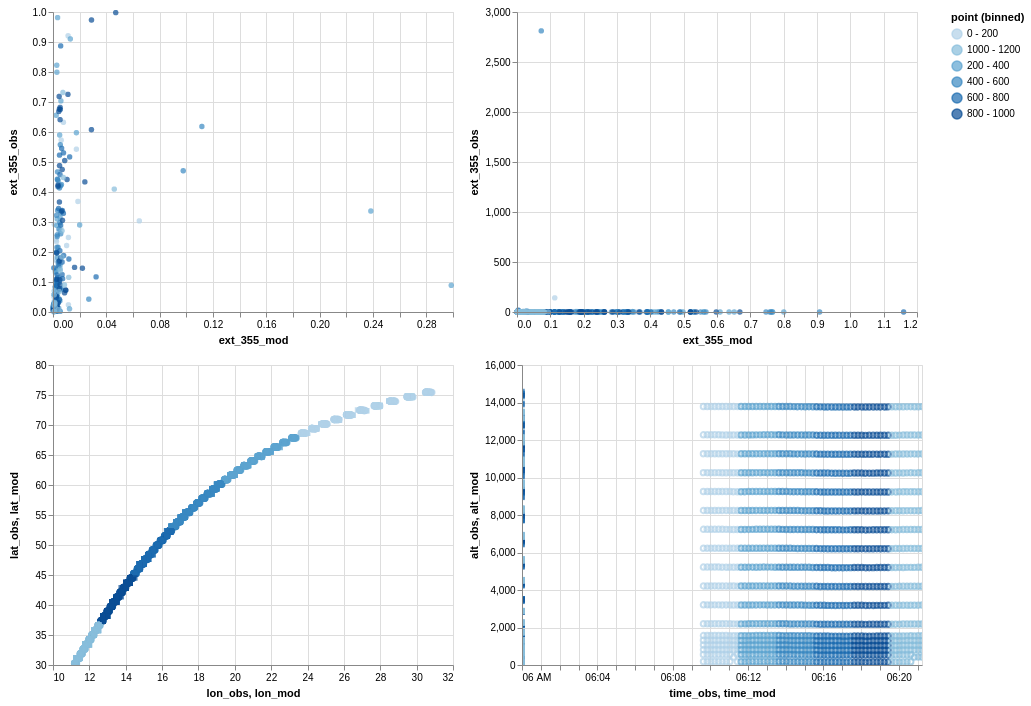

In [16]:
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(cast).encode(
    color=alt.condition(brush, alt.Color('point:O', bin=alt.Bin(maxbins=10)), alt.value('lightgray')),
)

lonlat = base.mark_point().encode(
    alt.X('lon_obs:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_obs:Q', scale=alt.Scale(zero=False)),
    tooltip=['point:O', 'time_obs:T', 'lon_obs:Q', 'lat_obs:Q', 'alt_obs:Q']
) + base.mark_square().encode(
    alt.X('lon_mod:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_mod:Q', scale=alt.Scale(zero=False)),
    tooltip=['point:O', 'time_mod:T', 'lon_mod:Q', 'lat_mod:Q', 'alt_mod:Q']
).interactive()

timealt = base.mark_point().encode(
    x='time_obs:T',
    y='alt_obs:Q',
    tooltip=['point:O', 'time_obs:T', 'alt_obs:Q',]
) + base.mark_square().encode(
    x='time_mod:T',
    y='alt_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'alt_mod:Q',]
).interactive()

scatter = base.mark_circle().encode(
    y='ext_355_obs:Q',
    x='ext_355_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q', 'ext_355_mod:Q',]
).add_selection(
    brush
)

scatter_clean = scatter.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

( scatter_clean | scatter ) & ( lonlat | timealt )

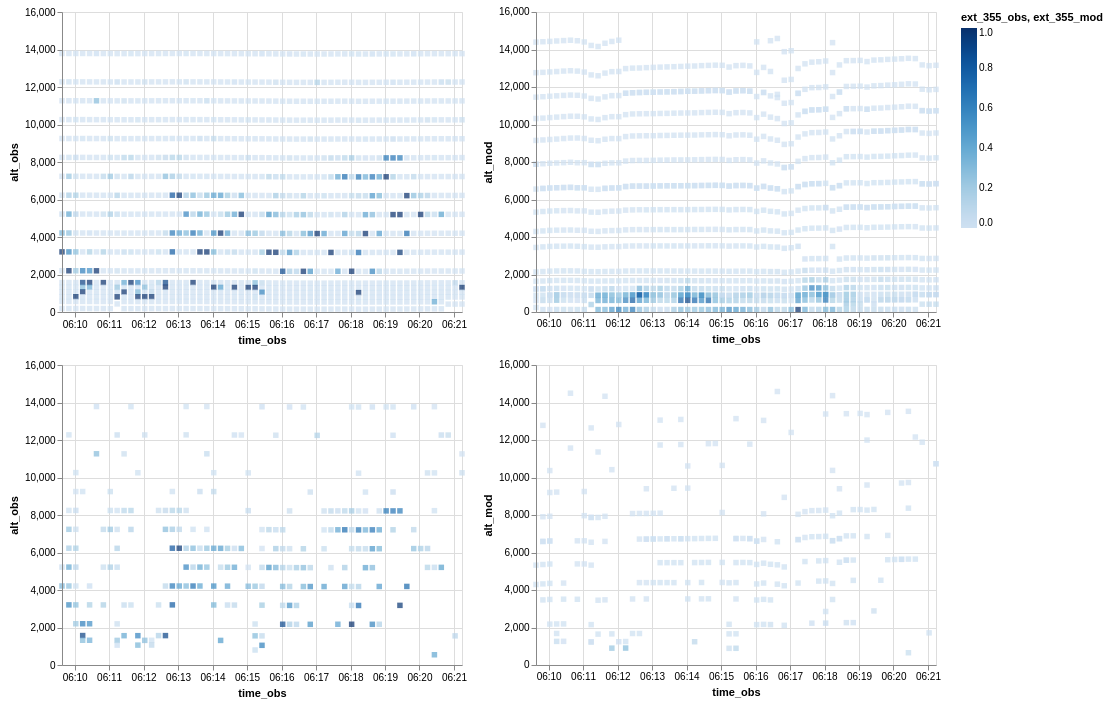

In [17]:
curtain_obs = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_obs:Q', scale=alt.Scale(domain=[0,16e3])),
    color=alt.condition(brush, alt.Color('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_obs:T', 'alt_obs:Q', 'ext_355_obs:Q']
).add_selection(
    brush
)

curtain_mod = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_mod:Q', scale=alt.Scale(domain=[0,16e3])),
    color=alt.condition(brush, alt.Color('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_mod:T', 'alt_mod:Q', 'ext_355_mod:Q']
).add_selection(
    brush
)

curtain_obs_clean = curtain_obs.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

curtain_mod_clean = curtain_mod.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

( curtain_obs | curtain_mod ) & ( curtain_obs_clean | curtain_mod_clean )